## AUTOMATIC CAPTION GENERATION

In [ ]:
from zipfile import ZipFile
d = ZipFile("/content/drive/My Drive/DL/Flickr8k_Dataset.zip")
d.extractall(path = "/content/flikr8kimages")
with ZipFile("/content/drive/My Drive/DL/Flickr8k_text.zip") as d:
    d.extractall(path = "/content/flikr8ktext")

### PREPROCESSING THE DATA 

In [ ]:
from collections import defaultdict as dfd

In [ ]:
# the tokens contain image name with 5 captions
tokens_loc = "/content/flikr8ktext/Flickr8k.token.txt"
image_captions = dfd(list)

with open(tokens_loc, 'r') as tk:
    # print(tk.read().split('\n')[0].split()[0].split('.')[0])
    for row in tk.read().strip().split('\n'):
        if len(row)<1:
            continue
        row_dat = row.split()
        name, caption = row_dat[0], row_dat[1:]
        name = name.split('.')[0]
        caption = ' '.join(caption)
        image_captions[name].append(caption)


In [ ]:
image_captions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [ ]:
# making all words lowercase and removing punctuations
import string
table = str.maketrans('', '', string.punctuation)
for img,cap in image_captions.items():
    for i in range(len(cap)):
        capt = cap[i].split()

        capt = [w.lower() for w in capt]
        capt = [w.translate(table) for w in capt]
        capt = [w for w in capt if len(w)>1]
        capt = [w for w in capt if w.isalpha()]

        cap[i] = ' '.join(capt)


In [ ]:
image_captions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

this vocabulary is for whole dataset but it wont be used in training

In [ ]:
# creating vocabulary
vocabulary = set()
for cap_list in image_captions.values():
    for cap in cap_list:
        vocabulary.update(cap.split())

print(len(vocabulary))

8763


we'll remove the less frequent words from our vocabulary to make the vocabulary smaller 

In [ ]:
word_count = dfd(lambda:0)
for li in image_captions.values():
    for sent in li:
        for word in sent.strip().split():
            word_count[word]+=1 


In [ ]:
print(len(word_count.keys()))

8763


this vocabulary is for whole dataset but it wont be used in training

In [ ]:
word_count_threshold = 10
vocabulary_final = [word for word in word_count if word_count[word]>=word_count_threshold]

In [ ]:
len(vocabulary_final)

1947

In [ ]:
# import pprint; pprint.pprint(vocabulary_final)
sents = [] 
for cap_list in image_captions.values():
    for w in cap_list:
        sents.append(w.split())

In [ ]:
sents[0]

['child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way']

this maxlength is for whole dataset but it wont be used in training

In [ ]:
max_len_sent = max(sents, key = len)
print(len(max_len_sent))

32


getting the training image file names

In [ ]:
train_data_file = "/content/flikr8ktext/Flickr_8k.trainImages.txt"
train = [] 
with open(train_data_file, 'r') as tdf:
    for i in tdf.read().strip().split('\n'):
        name = i.split('.')[0]
        train.append(name)

In [ ]:
print(len(train), train[0])

6000 2513260012_03d33305cf


getting the test file names

In [ ]:
test_data_file = "/content/flikr8ktext/Flickr_8k.testImages.txt"
test = [] 
with open(test_data_file, 'r') as tdf:
    for i in tdf.read().strip().split('\n'):
        name = i.split('.')[0]
        test.append(name)

In [ ]:
print(len(test), test[0])

1000 3385593926_d3e9c21170


adding startseq and endseq at the ends of each captions to mark the begining and ending of a sentence

In [ ]:
for k in image_captions:
    for i in range(len(image_captions[k])):
        image_captions[k][i] = 'startseq ' + image_captions[k][i] + ' endseq'

In [ ]:
image_captions['3385593926_d3e9c21170']

['startseq the dogs are in the snow in front of fence endseq',
 'startseq the dogs play on the snow endseq',
 'startseq two brown dogs playfully fight in the snow endseq',
 'startseq two brown dogs wrestle in the snow endseq',
 'startseq two dogs playing in the snow endseq']

## Loading and pre processing images

In [ ]:
from PIL import Image
import glob
from pickle import dump, load
import re
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
import numpy as np

Using inception model to get smaller representation of images

In [ ]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(299, 299))
    # (299, 299) is the size expected by inceptionv3 model
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess_images(image) # preprocess the image; variable image is path to the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
def get_path(name):
    name+='.jpg'
    name = "/content/flikr8kimages/Flicker8k_Dataset/"+name 
    return name

encoding test images

In [ ]:
test_name_to_imgarray_dict = {}
for name in test:
    x = encode(get_path(name))
    test_name_to_imgarray_dict[name] = x 
    

In [ ]:
test_name_to_imgarray_dict['3385593926_d3e9c21170'].shape

(2048,)

In [ ]:
with open("/content/drive/My Drive/DL/encoded_test.pkl", "wb") as encoded_pickle:
    dump(test_name_to_imgarray_dict, encoded_pickle)

In [ ]:
# testingpkl = {} 
# with open("/content/drive/My Drive/DL/encoded_test.pkl", "rb") as encoded_pickle:
#     testingpkl  = load(encoded_pickle)

In [ ]:
# testingpkl['1056338697_4f7d7ce270'].shape

encoding training images

In [ ]:
train_name_to_imgarray_dict = {}
for name in train:
    x = encode(get_path(name))
    train_name_to_imgarray_dict[name] = x 

with open("/content/drive/My Drive/DL/encoded_train.pkl", "wb") as encoded_pickle:
    dump(train_name_to_imgarray_dict, encoded_pickle)

In [ ]:
train_name_to_imgarray_dict['1003163366_44323f5815'].shape

(2048,)

In [ ]:
# testingpkl = {} 
# with open("/content/drive/My Drive/DL/encoded_train.pkl", "rb") as encoded_pickle:
#     testingpkl  = load(encoded_pickle)
# testingpkl['1003163366_44323f5815'].shape

(2048,)

load images from pickle

In [ ]:
train_images = {} 
with open("/content/drive/My Drive/DL/encoded_train.pkl", "rb") as encoded_pickle:
    train_images  = load(encoded_pickle)

In [ ]:
train_images['1003163366_44323f5815'].shape

(2048,)

In [ ]:
test_images = {} 
with open("/content/drive/My Drive/DL/encoded_test.pkl", "rb") as encoded_pickle:
    test_images  = load(encoded_pickle)

In [ ]:
test_images['1056338697_4f7d7ce270'].shape

(2048,)

## Creating vocabulary from training examples

words present in test set but not in train set will not be considered for model training

In [ ]:
train_captions = [] 
for image_names in train:
    train_captions.extend(image_captions[image_names])

In [ ]:
train_captions[0]

'startseq black dog is running after white dog in the snow endseq'

In [ ]:
word_count_train = dfd(int)
for sen in train_captions:
    for w in sen.split():
        word_count_train[w]+=1 


In [ ]:
len(word_count_train.keys())

7578

In [ ]:
train_words_final = [w for w in word_count_train if word_count_train[w]>=word_count_threshold]

In [ ]:
len(train_words_final)

1651

In [ ]:
max_len_sent_train = max([x.split() for x in train_captions], key = len)

In [ ]:
max_len_of_train = len(max_len_sent_train)
max_len_of_train

34

In [ ]:
word2idx = {}
idx2word = {}
i = 1 
for w in train_words_final:
    word2idx[w] = i 
    idx2word[i] = w 
    i+=1 

In [ ]:
vocab_size_train = len(word2idx) + 1 # +1 for padding
vocab_size_train

1652

## setting up embeddings layer

In [ ]:
# downloading http://nlp.stanford.edu/data/glove.6B.zip
with open('glove.6B.zip','wb') as gv:
    import requests; 
    gv.write(requests.get("http://nlp.stanford.edu/data/glove.6B.zip").content)

In [ ]:
cp "/content/drive/My Drive/DL/glove.6B.zip" "/content/" 

In [ ]:
# extracting the glove vec
from zipfile import ZipFile
with ZipFile("/content/glove.6B.zip") as d:
    d.extractall(path = "/content/glove6B")

In [ ]:
  # Load Glove vectors
embeddings_index = {} # empty dictionary to contain words and resp embeddings
f = open("/content/glove6B/glove.6B.200d.txt", encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200
# Get 200-dim dense vector for each of the words in our vocabulary
embedding_matrix = np.zeros((vocab_size_train, embedding_dim))

for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embeddings will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

## **CREATING THE MODEL**

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
# encoded image
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# words
inputs2 = Input(shape=(max_len_of_train,))
se1 = Embedding(vocab_size_train, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

outputs = Dense(vocab_size_train, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

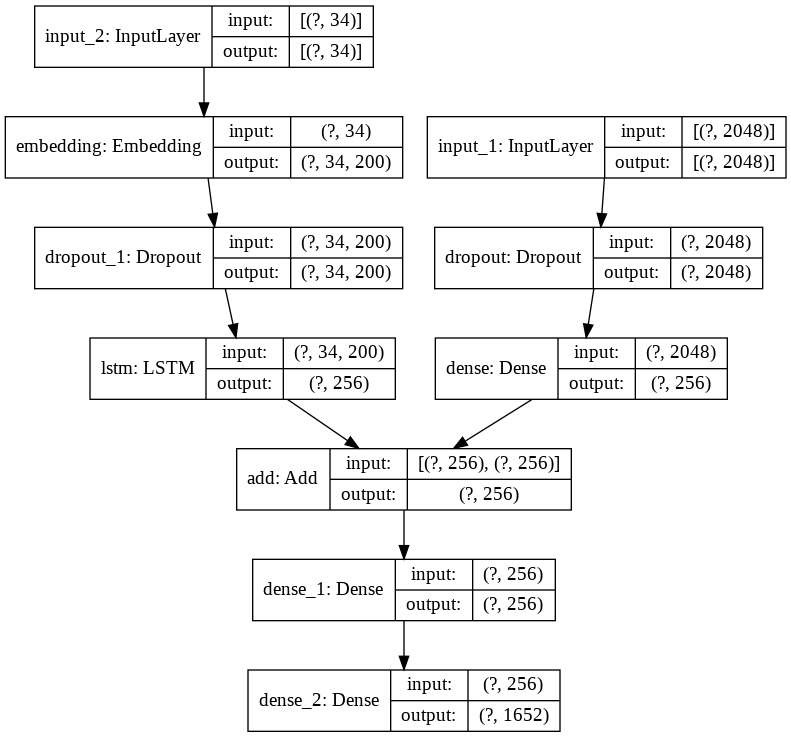

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    x1 = [] # images
    x2 = [] # initial seq of caption
    y = [] # next word of caption
    n = 0 
    c=0
    while 1:
        for name, cap_list in descriptions.items():
            n+=1
            img = photos[name]
            for cap in cap_list:
                cap_vec = []
                for w in cap.split():
                    if w in wordtoix:
                        cap_vec.append(wordtoix[w])
                for i in range(1, len(cap_vec)):
                    ip = cap_vec[:i]
                    op  = cap_vec[i:i+1]
                    ip =  pad_sequences([ip], padding='post', value = 0,  maxlen=max_length)[0]
                    op = to_categorical([op], num_classes=vocab_size_train)[0]
                    
                    x1.append(img)
                    x2.append(ip)
                    y.append(op)
                    
            if n==num_photos_per_batch:
                yield [[np.asarray(x1),np.asarray(x2)]], [np.asarray(y)]
                x1, x2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 10
pics_per_step = 3
steps = len(train_images.keys())//pics_per_step

In [ ]:
steps

2000

In [ ]:
train_captions_dict = {img: image_captions[img] for img in train_images}

In [ ]:
for i in range(epochs):
    generator = data_generator(train_captions_dict, train_images, word2idx, max_len_of_train, pics_per_step)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/model_weights/model_loop1_' + str(i) + '.h5')

2000/2000 [==============================] - 782s 391ms/step - loss: 2.6977


In [ ]:
cp "/content/model_weights/model_loop1_9.h5" "/content/drive/My Drive/DL/loop1 weights"

In [ ]:
cp  "/content/drive/My Drive/DL/loop1 weights/model_loop1_9.h5" "/content/weight loop1"

In [ ]:
model = load_model("/content/weight loop1/model_loop1_9.h5")

In [ ]:
epochs = 10
pics_per_step = 3
steps = len(train_images.keys())//pics_per_step

for i in range(epochs):
    generator = data_generator(train_captions_dict, train_images, word2idx, max_len_of_train, pics_per_step)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/model_weights/model_loop1_' + str(i) + '.h5')

2000/2000 [==============================] - 725s 362ms/step - loss: 2.5229


In [ ]:
!cp "/content/model_weights/model_loop1_0.h5" "/content/drive/My Drive/DL/loop2 weights"

In [ ]:
model = load_model("/content/drive/My Drive/DL/loop2 weights/model_loop1_9.h5")

In [ ]:
model.optimizer.lr = 0.0001
epochs = 10
pics_per_step = 6
steps = len(train_images.keys())//pics_per_step
steps

1000

In [ ]:
for i in range(epochs):
    generator = data_generator(train_captions_dict, train_images, word2idx, max_len_of_train, pics_per_step)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/DL/loop3 final weights/model_loop1_' + str(i) + '.h5')

1000/1000 [==============================] - 665s 665ms/step - loss: 2.3617


## TESTING

In [ ]:
model = load_model("/content/drive/My Drive/DL/loop3 final weights/model_loop1_9.h5")

In [ ]:
import matplotlib.pyplot as plt
from random import randrange

In [ ]:
def img_vec(pic):
    cap = image_captions[pic]
    fea_vec = test_images[pic]
    pic+='.jpg'
    path = "/content/flikr8kimages/Flicker8k_Dataset/"+pic
    img = image.load_img(path, target_size=(299, 299))
    return {'img':img, 'ip':fea_vec,'cap': cap}


testing on test set

In [ ]:
def greedy_search(pic_name):
    ip = 'startseq'
    var = img_vec(pic_name)
    pic_encoded = var['ip'].reshape((1,2048))
    pic_orig = var['img']

    plt.imshow(pic_orig)
    plt.title("original captions: \n"+'\n'.join([' '.join(x.split()[1:-1]) for x in var['cap']]))

    for i in range(max_len_of_train):
        ip_seq = [word2idx[w] for w in ip.split() if w in word2idx]
        ip_seq = pad_sequences([ip_seq], padding='post', value = 0,  maxlen=max_len_of_train)[0].reshape((1,34))
        op_vec = model.predict([pic_encoded, ip_seq], verbose = 0 )
        op_word_idx = np.argmax(op_vec)
        op_word = idx2word[op_word_idx]
        ip+=' '+op_word 
        if op_word=='endseq':
            break 

    print("output seq: "+' '.join(ip.split()[1:-1]))

output seq: man and woman walk on the beach


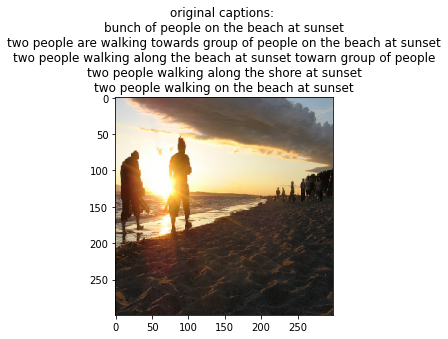

In [ ]:
greedy_search(test[randrange(0,1000)])

output seq: two men in basketball uniforms playing basketball


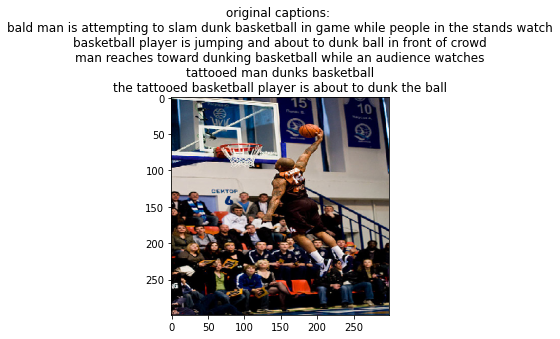

In [ ]:
greedy_search(test[randrange(0,1000)])

output seq: skateboarder is doing trick on ramp


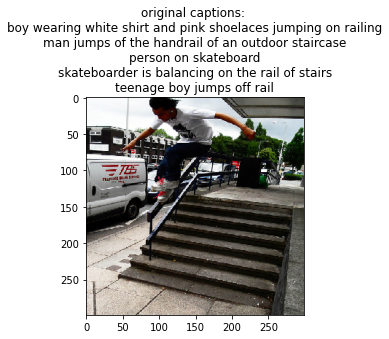

In [ ]:
greedy_search(test[randrange(0,1000)])

output seq: two young women wearing skimpy outfits are standing in front of crowd


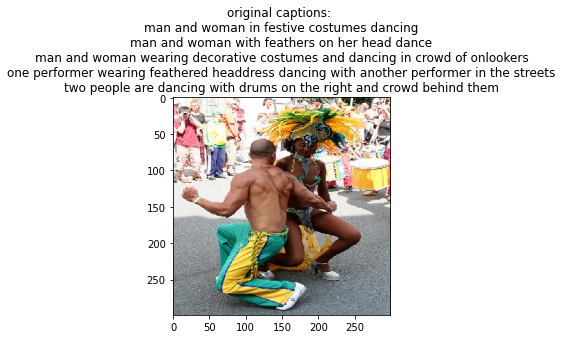

In [ ]:
greedy_search(test[randrange(0,1000)])

output seq: black dog is running through the grass


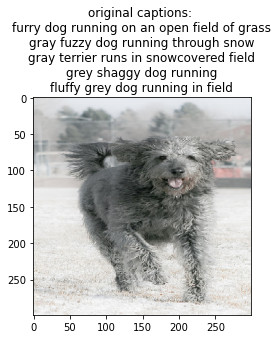

In [ ]:
greedy_search(test[randrange(0,1000)])

testing on images from some different distribution

In [ ]:
inceptionv3 = model_new

In [ ]:
def generate_description(path):
    img = image.load_img(path, target_size=(299, 299))
    plt.imshow(img)
    img = preprocess_images(path)
    fea_vec = inceptionv3.predict(img).reshape((1,2048)) # Get the encoding vector for the image ; shape (1, 2048)
    ip = 'startseq'
    for i in range(max_len_of_train):
        ip_seq = [word2idx[w] for w in ip.split() if w in word2idx]
        ip_seq = pad_sequences([ip_seq], padding='post', value = 0,  maxlen=max_len_of_train)[0].reshape((1,max_len_of_train))
        op_vec = model.predict([fea_vec, ip_seq], verbose = 0 )
        op_word_idx = np.argmax(op_vec)
        op_word = idx2word[op_word_idx]
        ip+=' '+op_word 
        if op_word=='endseq':
            break 

    print("output seq: "+' '.join(ip.split()[1:-1]))

output seq: man in swimming trunks is jumping into swimming pool


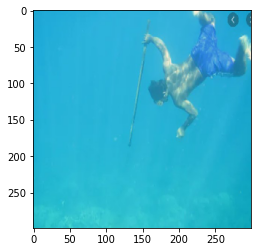

In [ ]:
generate_description("/content/6.jpg")

output seq: man and woman walk along the beach


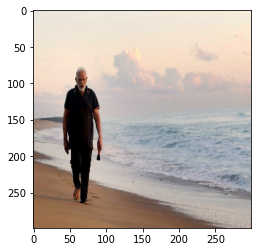

In [ ]:
generate_description("/content/2.jpg")

output seq: two girls dance in gym


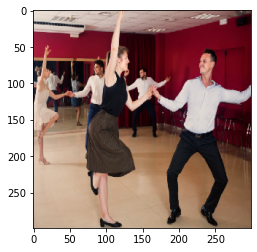

In [ ]:
generate_description("/content/3.jpg")

output seq: man in red and white uniform is riding red motorcycle


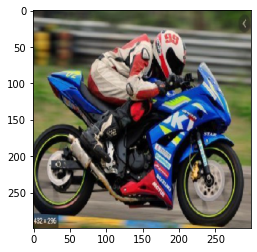

In [ ]:
generate_description("/content/11.jpg")

output seq: man on bike is riding in the air


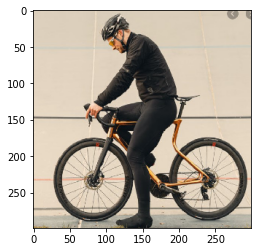

In [ ]:
generate_description("/content/9.jpg")

## References
[preprocessing example](https://machinelearningmastery.com/prepare-photo-caption-dataset-training-deep-learning-model/), 
[Keras Functional Api](https://keras.io/guides/functional_api/), 
[Flickr 8k Images](http://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip), 
[Flickr labels](http://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip), 
[glove 6B 200d word embeddings](http://nlp.stanford.edu/data/glove.6B.zip)